In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import rioxarray as rxr

In [2]:
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt 

In [3]:
import xarray as xr

# Replace with the path to your .nc file
dataset_path = "./vp/vp_1980subset.nc"
ds = xr.open_dataset(dataset_path)
print(ds['vp'])


<xarray.DataArray 'vp' (time: 365, lat: 135, lon: 166)> Size: 33MB
[8179650 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 1kB 42.82 42.83 42.84 42.85 ... 44.14 44.15 44.16
  * lon      (lon) float64 1kB -80.32 -80.31 -80.3 ... -78.69 -78.68 -78.67
  * time     (time) datetime64[ns] 3kB 1980-01-01T12:00:00 ... 1980-12-30T12:...


In [4]:
ds_cleaned = ds.sel(time=ds['time'].dt.month.isin(range(4,10)))
print(ds_cleaned)

<xarray.Dataset> Size: 16MB
Dimensions:  (lat: 135, lon: 166, time: 183)
Coordinates:
  * lat      (lat) float64 1kB 42.82 42.83 42.84 42.85 ... 44.14 44.15 44.16
  * lon      (lon) float64 1kB -80.32 -80.31 -80.3 ... -78.69 -78.68 -78.67
  * time     (time) datetime64[ns] 1kB 1980-04-01T12:00:00 ... 1980-09-30T12:...
Data variables:
    vp       (time, lat, lon) float32 16MB ...
Attributes:
    regrid_method:  bilinear


<xarray.DataArray 'tmax' (lat: 134, lon: 165)> Size: 88kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 1kB 42.83 42.84 42.85 42.86 ... 44.14 44.15 44.16
  * lon      (lon) float64 1kB -80.31 -80.3 -80.29 ... -78.69 -78.68 -78.67


Text(0, 0.5, 'Latitude')

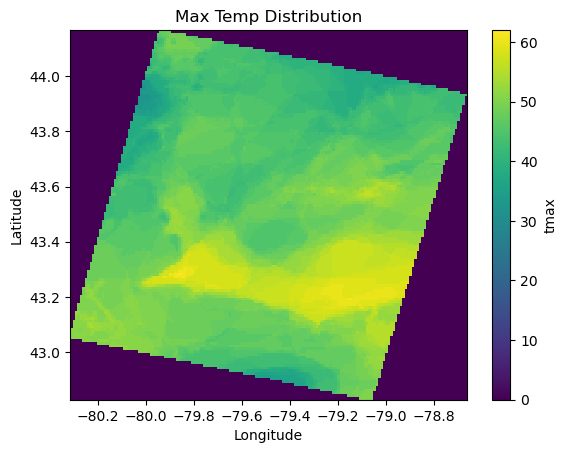

In [5]:
ds_tmax = xr.open_dataset("./tmax/tmax_1980subset.nc")
#Reducing Dataset to just April to October
# print(tmax_cleaned['lon'])
# print(tmax_cleaned['lat'])
# print(tmax_cleaned['tmax'])
# print(tmax_cleaned)
# for lat in tmax_cleaned['lat'].values:
#   print(lat)

# for log in tmax_cleaned['lon'].values:
#   print(log)
# Loop through each time point in the dataset
# Assuming ds_tmax is your xarray Dataset and it has been cleaned to include data from April to September

# Assuming ds_tmax is your xarray Dataset and 'tmax' is the data variable of interest
ds_tmax = xr.open_dataset("./tmax/tmax_1980subset.nc")

#filtered to summer
tmax_cleaned = ds_tmax.sel(time=ds['time'].dt.month.isin(range(6,9)))
# Use the .where() method to mask the dataset where 'tmax' values are greater than 25 degrees Celsius
# Then, use the .count() method to count the number of occurrences
# This function returns a lat and long map where all the values of T > 25 C
#Turns this into a 2d array by counting along the time dimension
days_over_25 = tmax_cleaned.where(ds_tmax['tmax'] > 25, drop=True)['tmax'].count(dim='time')

# 'days_over_25' is now a DataArray with the count of days where tmax > 25°C for each latitude and longitude
print(days_over_25)
days_over_25.plot()
plt.title('Max Temp Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


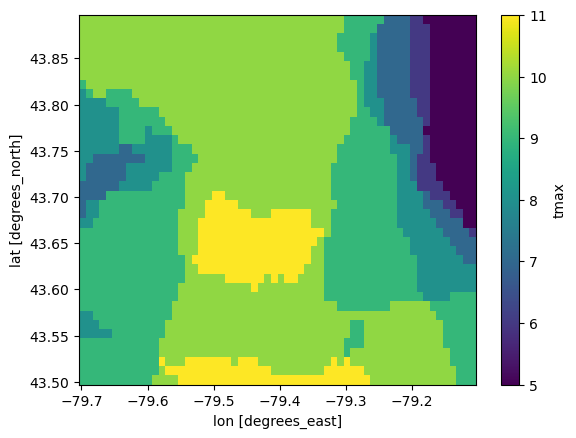

In [70]:
 #Write algo to iterate over every single one
#Add feature 
import os

#Directory base path
d_path = './tmax'
start_year = 1981
end_year = 2010
# Store in the format {'year': Dataset}
dict_of_temp_values = {}

ds = xr.open_mfdataset("./tmax/tmax_*subset.nc")
#Iterate through
for year in range(start_year, end_year + 1):
  #F string to concat into ospath
  # file_name = f"tmax_{year}subset.nc"
  # file_path = os.path.join(d_path, file_name)

  #Check if file exists
    # if os.path.exists(file_path):
    #Read into file
    ds_max = ds.sel(time = (ds.time.dt.year == year))
    # print(ds_max['time'])
    
    #Clean the dataset
    ds_cleaned = ds_max.sel(time=ds_max['time'].dt.month.isin(range(6,9)))
    # print(ds_cleaned['time'])
    
    #Normalize to 2Dims then remove unwanted lat and long values
    ds_long_lat = ds_cleaned.sel(lat=slice(43.5,43.9), lon=slice(-79.7, -79.1))
    # print(ds_long_lat['tmax'])
    ds_cleaned_over_25 = ds_long_lat.where(ds_long_lat['tmax'] >= 29).count(dim='time')['tmax']
    # print(ds_cleaned_over_25)
    # ds_cleaned_over_25 = ds_long_lat.where(ds_long_lat['tmax'] > 0, drop=True)['tmax'].count(dim='time')
    # print(ds_cleaned_over_25)

    # print(ds_cleaned_over_25)
    
    # print(f"Processing {year}...")
    
    dict_of_temp_values[year] = ds_cleaned_over_25
      

dict_of_temp_values[2008].plot()


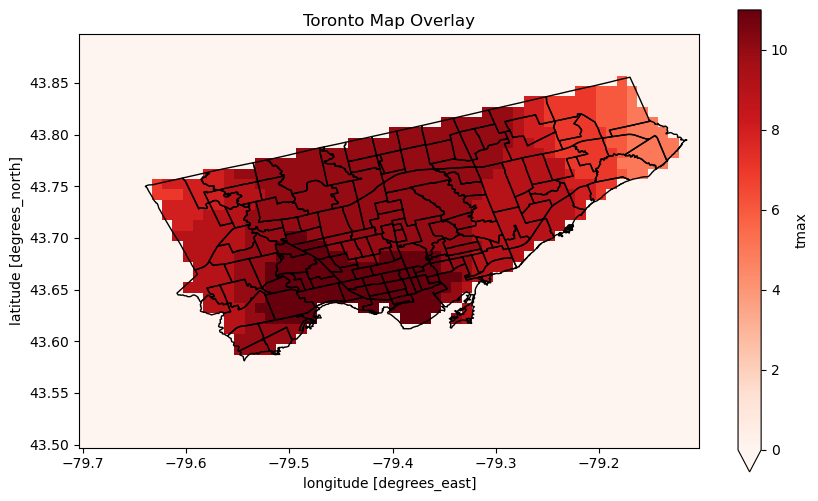

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt

test_data = dict_of_temp_values[2008]

# Load your Toronto shapefile
toronto_map = gpd.read_file('toronto_neighbourhood_shape.shp', crs="epsg:4326")

test_data = test_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
test_data = test_data.rio.write_crs("epsg:4326")

#dict_of_temp_values = dict_of_temp_values.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
#dict_of_temp_values = dict_of_temp_values.rio.write_crs("epsg:4326")
#dict_of_temp_values = dict_of_temp_values.rio.clip(toronto_map.geometry.values, toronto_map.crs, drop = False, invert = False)

test_data = test_data.rio.clip(toronto_map.geometry.values, toronto_map.crs, drop = False, invert = False)

fig, ax = plt.subplots(figsize=(10, 6))
test_data.plot.pcolormesh(ax = ax, vmin = 0, cmap = 'Reds')
toronto_map.plot(ax=ax, edgecolor='black', facecolor='none')


# Overlay your data
# This assumes you've converted your data into a format compatible with matplotlib
# For complex data manipulations, consider rasterio to work with raster data and overlay it
# Plotting directly depends on your dataset's format and may require conversion or rasterization

ax.set_title('Toronto Map Overlay')
plt.show()


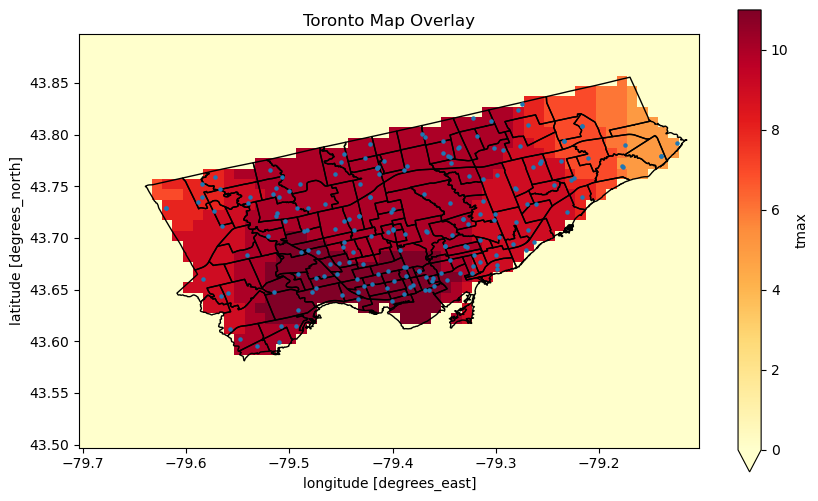

In [78]:
test_data = dict_of_temp_values[2008]

# Load your Toronto shapefile
toronto_map = gpd.read_file('toronto_neighbourhood_shape.shp', crs="epsg:4326")

test_data = test_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
test_data = test_data.rio.write_crs("epsg:4326")

#dict_of_temp_values = dict_of_temp_values.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
#dict_of_temp_values = dict_of_temp_values.rio.write_crs("epsg:4326")
#dict_of_temp_values = dict_of_temp_values.rio.clip(toronto_map.geometry.values, toronto_map.crs, drop = False, invert = False)

test_data = test_data.rio.clip(toronto_map.geometry.values, toronto_map.crs, drop = False, invert = False)

fig, ax = plt.subplots(figsize=(10, 6))
test_data.plot.pcolormesh(ax = ax, vmin = 0, cmap = 'YlOrRd')
toronto_map.plot(ax=ax, edgecolor='black', facecolor='none')

cooling_center_data_without_pools_shelters = pd.read_csv('cooling_centres_minus_pools_and_shelters.csv')

lons = []
lats = []
for i in range(len(cooling_center_data_without_pools_shelters['geometry'])):
    coords = np.array(cooling_center_data_without_pools_shelters['geometry'][i][40:][:-3].split(',')).astype(float)
    lons.append(coords[0])
    lats.append(coords[1])

ax.scatter(lons, lats, s = 5)

# Overlay your data
# This assumes you've converted your data into a format compatible with matplotlib
# For complex data manipulations, consider rasterio to work with raster data and overlay it
# Plotting directly depends on your dataset's format and may require conversion or rasterization

ax.set_title('Toronto Map Overlay')
plt.show()

